# 3D Code for  isothermal finite hyperelasticity

Simple stretch

Basic units:
Length: mm
Mass: kg
Time:  s
Derived units:
Force: milliNewtons
Stress: kPa 

Eric Stewart and Lallit Anand   
ericstew@mit.edu and anand@mit.edu   

Converted to FEniCSx by Jorge Nin
jorgenin@mit.edu
September 2023



In [1]:
import numpy as np
import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from basix.ufl import element, mixed_element
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split)
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

### Set level of detail for log messages (integer)
Guide: \
CRITICAL  = 50  errors that may lead to data corruption \
ERROR     = 40  things that HAVE gone wrong \
WARNING   = 30  things that MAY go wrong later \
INFO      = 20  information of general interest (includes solver info) \
PROGRESS  = 16  what's happening (broadly) \
TRACE     = 13  what's happening (in detail) \
DBG       = 10  sundry 


In [2]:
log.set_log_level(log.LogLevel.WARNING)

# Define Geometry

In [3]:
length = 10.0 # mm
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[length,length,length]],[2,2,2],mesh.CellType.tetrahedron)

### Visualize Gemometry

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:57474/index.html?ui=P_0x29002e8d0_0&reconnect=auto' style='width: …

## Functions for finding Differnent Areas

In [5]:
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], length)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], length)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], length)

In [6]:
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)

In [7]:
facet_tag.topology.create_connectivity(fdim, domain.topology.dim)

## MATERIAL PARAMETERS
Arruda-Boyce Model

In [8]:
Gshear_0 = Constant(domain,PETSc.ScalarType(280.0))          # Ground state shear modulus
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))             # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000.0*Gshear_0)) 

## Simulation Control

In [9]:
stretch  = 7.75      # stretch amplitude

dispTot  = (stretch-1)*length
rate     = 1.e-1
Ttot     = (stretch-1)/rate
numSteps = 100
dt       = Ttot/numSteps  # (fixed) step size

def distRamp(t):
    return dispTot*t/Ttot


## Function Spaces

$$ \frac{x}{y}$$


In [10]:

U2 = element("Lagrange", domain.basix_cell(), 2,shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For  pressure
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs


In [11]:
w = Function(ME)
u, p = split(w)
w_old         = Function(ME)
u_old,  p_old = split(w_old)

u_test, p_test = TestFunctions(ME)       
dw = TrialFunction(ME)           

## SubRoutine

In [12]:
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    J = det(F)
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
    zeta    = zeta_calc(u)
    Gshear  = Gshear_0 * zeta
    return Gshear

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Gshear  = Gshear_AB_calc(u)
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T   = T_calc(u,p)
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

In [13]:
F =  F_calc(u)  
J = det(F)
lambdaBar = lambdaBar_calc(u)

# Piola stress
Tmat = Piola_calc(u, p)

## WEAK FORMS

In [14]:
dxs = dx(metadata={'quadrature_degree': 4})

In [15]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)

# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , grad(u_test) )*dxs

# The weak form for the pressure
fac_p = ln(J)/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dxs

# Total weak form
Res = Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [16]:
Time_cons = Constant(domain,PETSc.ScalarType(distRamp(0)))

#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

xBot_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
yBot_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(3))
zBot_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tag.dim, facet_tag.find(5))
yTop_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(4))

bcs_1 = dirichletbc(0.0, xBot_dofs,ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_dofs, ME.sub(0).sub(1))  # u2 fix - yBot
bcs_3 = dirichletbc(0.0,zBot_dofs ,ME.sub(0).sub(2))  # u3 fix - zBot
#
bcs_4 = dirichletbc(Time_cons, yTop_dofs, ME.sub(0).sub(1))  # disp ramp - yTop
bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

## Non Linear Variational

In [17]:
#Setting up visualziation
import matplotlib
import cmasher as cmr
import os
pyvista.start_xvfb()
if not os.path.exists("results"):

   # Create a new directory because it does not exist
   os.makedirs("results")

plotter = pyvista.Plotter()
plotter.open_gif("results/FiniteElasticStrech.gif")


V = functionspace(domain,U2) ## Difference 
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)


topology, cells, geometry = plot.vtk_mesh(u_n.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
#u0 = w.sub(0).collapse()
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")


# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=0)
warped.set_active_vectors("u")


cmap = cmr.get_sub_cmap(matplotlib.colormaps.get_cmap("jet"), 0.1, 0.9,N=6)
# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 67.5],cmap=cmap)

# Compute magnitude of displacement to visualize in GIF 
Vs = functionspace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(u_n[1], Vs.element.interpolation_points())
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array

plotter.view_xy()
plotter.camera.position=[5,25,200]
plotter.camera.focal_point=[5,40,0]
plotter.write_frame()



In [18]:
## Functions for visualization


U1 =  element("Lagrange", domain.basix_cell(), 1,shape=(3,)) # For displacement
V2 = functionspace(domain, U1)#Vector function space
V1 = functionspace(domain, P1)#Scalar function space

u_r = Function(V2)

u_r.name = "disp"

p_r = Function(V1)

p_r.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())


lambdaBar_Vis = Function(V1)
lambdaBar_Vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())


P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_Vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

def InterpAndSave(t,file):
    u_r.interpolate(w.sub(0))
    p_r.interpolate(w.sub(1))
    J_vis.interpolate(J_expr)
    P11.interpolate(P11_expr)
    P22.interpolate(P22_expr)
    P33.interpolate(P33_expr)
    lambdaBar_Vis.interpolate(lambdaBar_expr)
    Mises_Vis.interpolate(Mises_expr)

    file.write_function(u_r,t)
    file.write_function(p_r,t)
    file.write_function(J_vis,t)
    file.write_function(P11,t)
    file.write_function(P22,t)
    file.write_function(P33,t)
    file.write_function(lambdaBar_Vis,t)
    file.write_function(Mises_Vis,t)


pointForStress = [length,length,length]
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))
 
area= Constant(domain,(length*length))
engineeringStress= fem.form(P22/area*ds(4)) #P22/area*ds

In [19]:

startTime = datetime.now()

jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}



problem = NonlinearProblem(Res, w, bcs, a,jit_options=jit_options)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

totSteps = numSteps+1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 

step = "Strech"
t = 0
ii = 0

xdmf = XDMFFile(domain.comm, "results/finite_elastic_strech.xdmf", "w")
xdmf.write_mesh(domain)



InterpAndSave(t,xdmf)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    Time_cons.value = distRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print( "Ended Early")
        break

    w.x.scatter_forward()
    # Write output to *.xdmf file
    #writeResults(t)
    #print(u0.x.array-w.x.array[dofs])

    #Visualizing GIF
    u_n.interpolate(u_ex)
    function_grid["u"][:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))
   
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalars(magnitude.x.array,render = False)
    
    plotter.write_frame()

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array


    #SAVING RESULT
    InterpAndSave(t,xdmf)

    # Store  displacement at a particular point  at this time
    timeHist0[ii] = w.sub(0).sub(1).eval([length, length, length],colliding_cells.array[0])[0] # time history of displacement
    #
    
    timeHist1[ii] =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0] # time history of engineering stress
    
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
              format(step, round(t,4), current_time))
        print("Iterations: {}".format(iter))
        print()  
             
plotter.close()
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")
xdmf.close()

------------------------------------
Simulation Start
------------------------------------


AttributeError: 'numpy.ndarray' object has no attribute 'array'

05.898023
08.209695

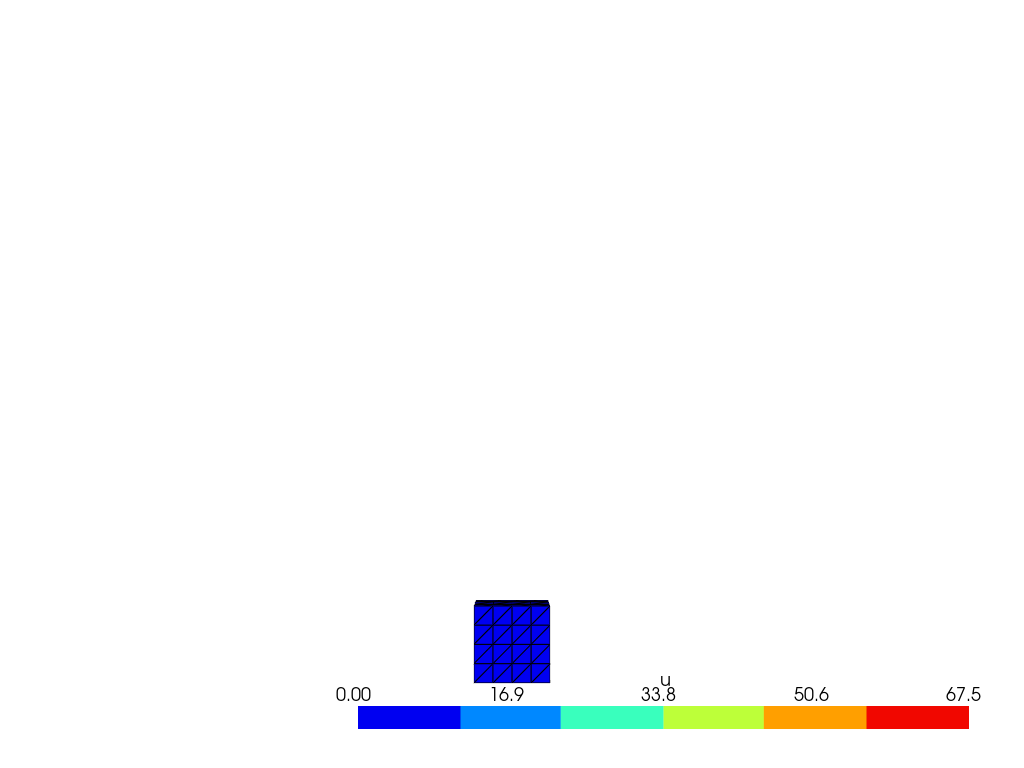

In [ ]:
from IPython.display import Image
display(Image(data=open("results/FiniteElasticStrech.gif",'rb').read(), format='png'))

In [ ]:
pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()

V = fem.VectorFunctionSpace(domain,("Lagrange",2))
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)

topology, cells, geometry = plot.vtk_mesh(V)

function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")

warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 67.5])

# Compute magnitude of displacement to visualize in GIF 
Vs = FunctionSpace(domain,("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(u_n[1], Vs.element.interpolation_points())
magnitude.interpolate(Mises_Vis)
warped["mag"] = magnitude.x.array
#print(u_n.function_space.dofmap.list)
plotter.update_scalars(magnitude.x.array,render = False)
plotter.camera.position=[5,25,200]
plotter.camera.focal_point=[5,40,0]
plotter.render()
plotter.show()


AttributeError: module 'dolfinx.fem' has no attribute 'VectorFunctionSpace'

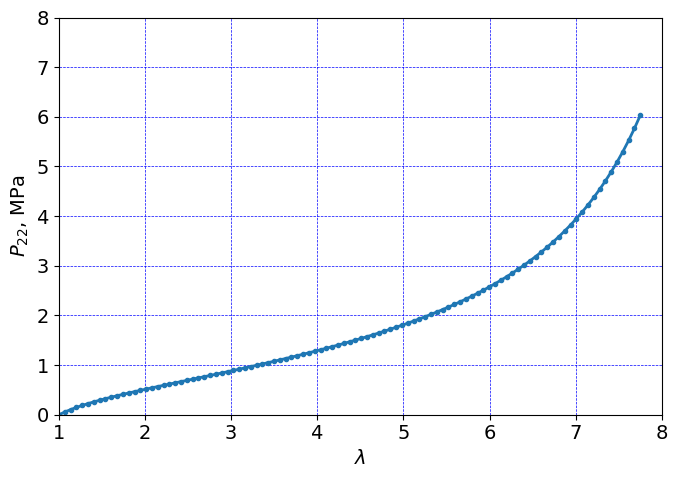

In [ ]:
import matplotlib.pyplot as plt
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#plt.figure()
plt.plot((length + timeHist0)/length, timeHist1/1.E3, linewidth=2.0,\
         color=colors[0], marker='.')
plt.axis('tight')
plt.ylabel(r'$P_{22}$, MPa')
plt.xlabel(r'$\lambda$')
plt.xlim([1,8])
plt.ylim([0,8])
plt.grid(linestyle="--", linewidth=0.5, color='b')
# plt.show()   

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_finite_elastic_stress_stretch.png", dpi=600)
 